In [272]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

## Procesamiento de datos

In [273]:
ruta_datasets = 'data/'

In [274]:
dataset_sube20 = pd.read_csv(ruta_datasets+'dat-ab-usos-2020.csv')
dataset_sube21 = pd.read_csv(ruta_datasets+'dat-ab-usos-2021.csv')
dataset_sube22 = pd.read_csv(ruta_datasets+'dat-ab-usos-2022.csv')
dataset_sube = pd.read_csv(ruta_datasets+'sube-2023.csv')
dataset_sube_regresion = pd.read_csv(ruta_datasets+'sube-2023-regresion.csv')
poblacion_provincias = pd.read_excel(ruta_datasets+'poblacion_provincias.xlsx')
superficie_provincias = pd.read_excel(ruta_datasets+'superficie_provincias.xlsx')

In [275]:
df_concatenado = pd.concat([dataset_sube20,dataset_sube21,dataset_sube22,dataset_sube])

### Ejercicio 1

#### a)

Describimos el dataset

In [276]:
dataset_sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


Transformamos la columna dia_transporte a datetime

In [277]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

Creamos la columna fecha_dia con el nombre del día de la semana

In [278]:
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
def obtener_nombre_dia(fecha_dia):
    return dias[fecha_dia.weekday()]

In [279]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

Creamos la columna fecha_ordinal donde asignamos el numero de día del año a cada fecha

In [280]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

Creamos la columna fecha_mes con el numero de mes para cada fecha

In [281]:
dataset_sube['FECHA_MES'] = dataset_sube['DIA_TRANSPORTE'].dt.month

### Ejercicio 2

Creamos un dataframe que contiene solo los datos del AMBA y elimina los datos preliminares

In [282]:
datos_amba = dataset_sube[dataset_sube['AMBA']=='SI']
datos_amba = datos_amba[datos_amba['DATO_PRELIMINAR']=='NO']

Acomodamos el orden de las columnas y les corregimos el formato del nombre

In [283]:
datos_amba = datos_amba[['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL', 'JURISDICCION', 'LINEA','CANTIDAD', 'TIPO_TRANSPORTE']]

In [284]:
datos_amba = datos_amba.rename(columns={"DIA_TRANSPORTE": "fecha", "FECHA_DIA": "fecha_dia","FECHA_MES" : "fecha_mes", "FECHA_ORDINAL":"fecha_ordinal","JURISDICCION": "jurisdiccion", "LINEA":'linea',"CANTIDAD":"pasajeros", "TIPO_TRANSPORTE": "tipo_transporte"})

Resultado final:

In [285]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


### Ejercicio 3

#### a)

Calculamos la proporcion de pasajeros por transporte en 2023

In [286]:
pasajeros_totales = sum(datos_amba['pasajeros'])

In [287]:
pasajeros_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

In [288]:
proporcion_pasajeros = ((pasajeros_por_transporte/pasajeros_totales)*100).round(1)
proporcion_pasajeros = proporcion_pasajeros.map(lambda x: f"{x}%")
proporcion_pasajeros

tipo_transporte
COLECTIVO    83.8%
SUBTE         6.8%
TREN          9.4%
Name: pasajeros, dtype: object

#### b)

Creamos un dataset con los datos del Subte, agrupamos por mes y linea, y obtenemos el valor maximo

In [289]:
datos_subte = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']
datos_subte = datos_subte[['fecha_mes','linea','pasajeros']]

In [290]:
datos_subte_mesLinea = datos_subte.groupby(['fecha_mes','linea'])['pasajeros'].sum()

In [291]:
mes_linea_maxPasajeros = pd.DataFrame(datos_subte_mesLinea).idxmax()

Tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [292]:
mes_linea_maxPasajeros.iloc[0]

(8, 'LINEA_B')

#### c)

Creamos el dataset solo con los días habiles, calculamos el desvío estandar para cada día y vemos el menor

In [293]:
dias_habiles = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']
datos_amba_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

In [294]:
desvios = []
for dia_habil in dias_habiles:
    desvio_estandar = datos_amba_habiles[datos_amba_habiles['fecha_dia']==dia_habil]['pasajeros'].std().round(1)
    desvio_dia = (dia_habil, desvio_estandar)
    desvios.append(desvio_dia)
print(desvios)

[('Lunes', 33577.5), ('Martes', 35833.7), ('Miércoles', 35980.8), ('Jueves', 35968.3), ('Viernes', 35059.7)]


In [295]:
dia_menos_desvio = min(desvios, key=lambda x: x[1])
dia_menos_desvio[0]

'Lunes'

## Analisis exploratorio

### Ejercicio 4

- mediana, media, variacion, desvio estandar, promedio (.mean(), .std(), )
- cantidad de pasajeros por mes para cada transporte
- cantidad de pasajeros por provincia
- cantidad de pasajeros por año (sumar desde 2020)
- cantidad de pasajeros por municipio AMBA
- cantidad de pasajeros ?

In [296]:
df_concatenado['DIA_TRANSPORTE'] = pd.to_datetime(df_concatenado['DIA_TRANSPORTE'], format='%Y-%m-%d')
df_concatenado['AÑO'] = df_concatenado['DIA_TRANSPORTE'].dt.year

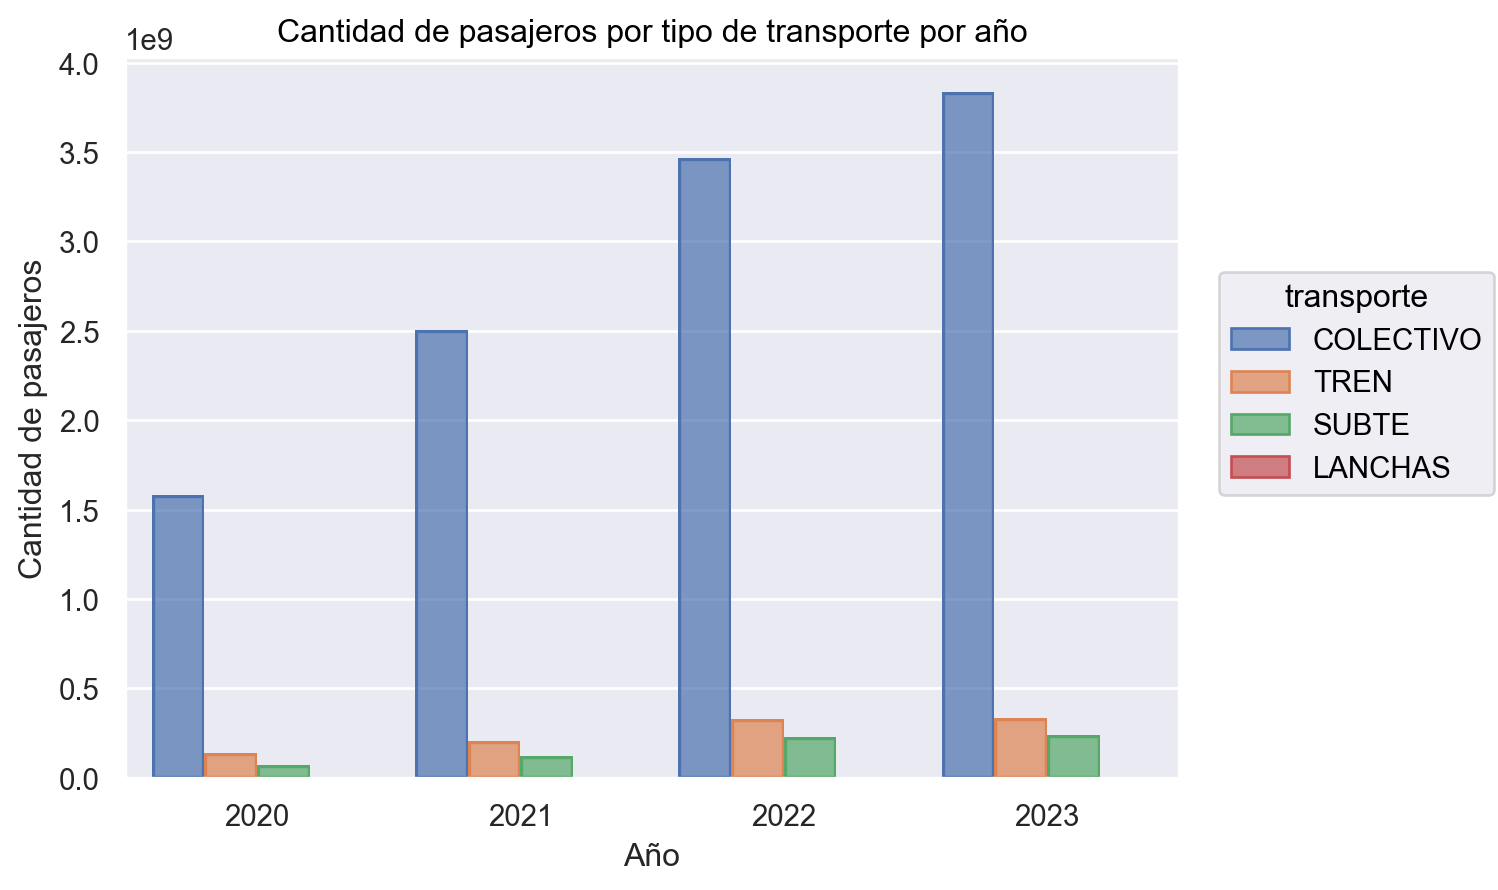

In [297]:
so.Plot(data=df_concatenado, x="AÑO", y="CANTIDAD", color = "TIPO_TRANSPORTE").add(so.Bar(), so.Agg("sum"), so.Dodge()).scale(x=so.Nominal()).label(title="Cantidad de pasajeros por tipo de transporte por año", x="Año", y="Cantidad de pasajeros", color= "transporte" )

En este grafico podemos ver que el uso del transporte publico incrementa año tras año, si bien hay que tener en cuenta que en el año 2020 el uso de este bajo abruptamente debido a la pandemia de COVID-19, la cual se extendio hacia inicios del 2021 en muchos sectores. Las oficinas al igual que los establecimientos educativos adoptaron modos de trabajo virtual, lo que consecuentemente hizo que la poblacion tenga que salir menos de sus casas y por lo tanto tomar menos colectivos, subtes, trenes y lanchas. A partir del 2022 se ve un fuerte incremento del uso de dichos transportes con la pandemia ya dejada de lado, es probable que con los incrementos de los costos de mantener un vehiculo propio en los proximos años sigan subiendo los numeros de pasajeros.

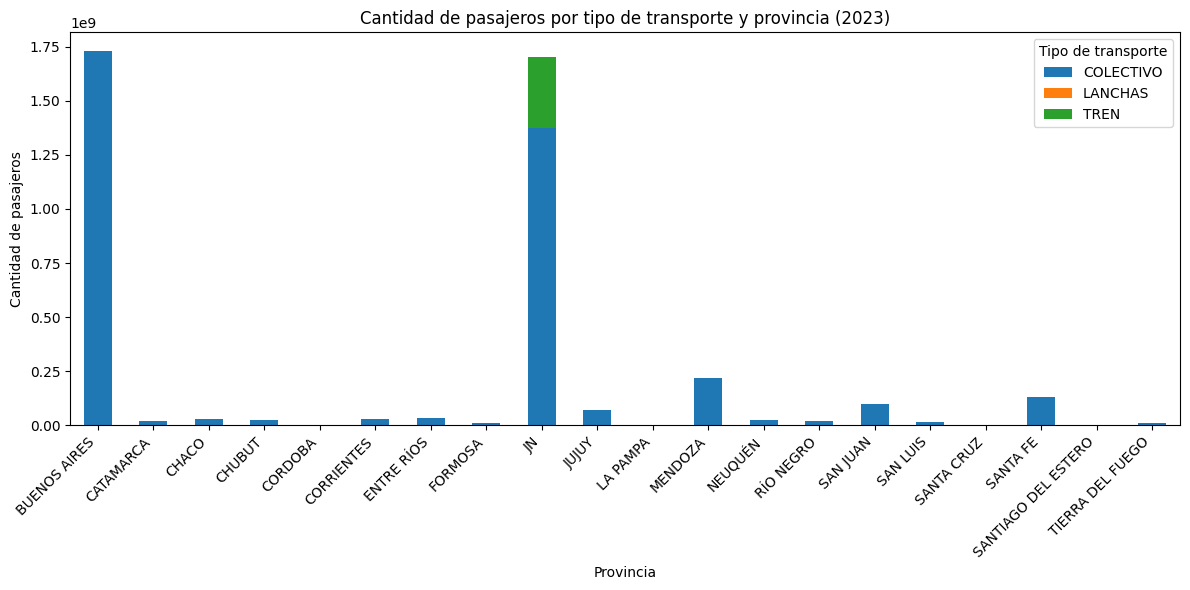

In [298]:
datos_agrupados = dataset_sube.groupby(['PROVINCIA', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().unstack()

# Crear el gráfico de barras apiladas
datos_agrupados.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Cantidad de pasajeros por tipo de transporte y provincia (2023)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de transporte')
plt.tight_layout()
plt.show()

<Axes: xlabel='fecha_dia', ylabel='pasajeros'>

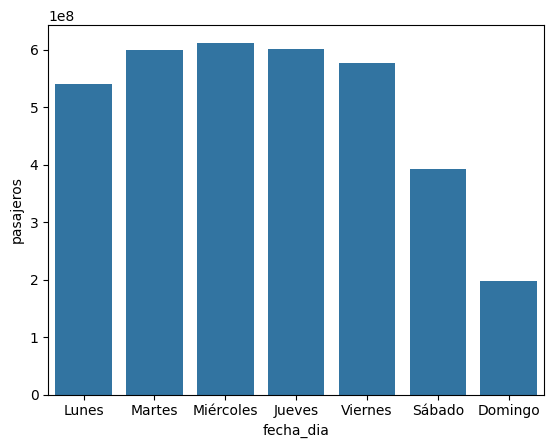

In [322]:
sns.barplot(data=datos_amba, x='fecha_dia', y='pasajeros', estimator='sum', order=dias, errorbar=None)

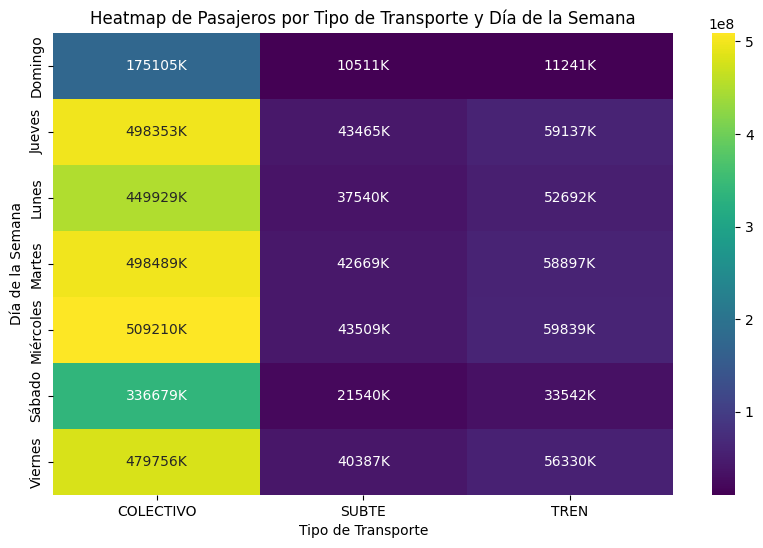

In [300]:
pivot_table = datos_amba.pivot_table(
    values='pasajeros', 
    index='fecha_dia', 
    columns='tipo_transporte', 
    aggfunc='sum', 
    fill_value=0
)

def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap de Pasajeros por Tipo de Transporte y Día de la Semana')
plt.xlabel('Tipo de Transporte')
plt.ylabel('Día de la Semana')

for t in heatmap.texts:
    t.set_text(thousands(float(t.get_text()), None))
    
plt.show()

In [301]:
agrupado_provincia = dataset_sube.groupby(['PROVINCIA'])['CANTIDAD'].sum().reset_index()

In [302]:
agrupado_provincia = agrupado_provincia.merge(poblacion_provincias,how='left', on='PROVINCIA')

In [303]:
agrupado_provincia_interior = agrupado_provincia[(agrupado_provincia['PROVINCIA']!='BUENOS AIRES') & (agrupado_provincia['PROVINCIA']!='JN')]

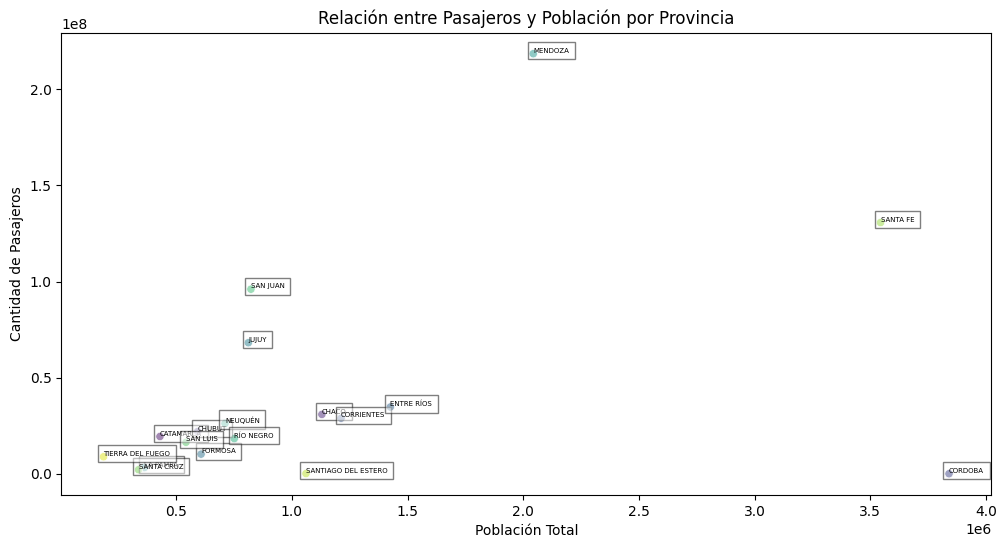

In [304]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=agrupado_provincia_interior, x='POBLACION', y='CANTIDAD', hue='PROVINCIA', palette='viridis', legend=False)
for index, row in agrupado_provincia_interior.iterrows():
    scatter.text(row['POBLACION'], row['CANTIDAD'], row['PROVINCIA'], ha='left', fontsize=5, 
                 va='bottom', rotation_mode='anchor', 
                 bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Población Total')
plt.ylabel('Cantidad de Pasajeros')
plt.title('Relación entre Pasajeros y Población por Provincia')
# plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Modelado

### Ejercicio 5

In [305]:
datos_ColectivoJN = dataset_sube_regresion[(dataset_sube_regresion['TIPO_TRANSPORTE']=='COLECTIVO') & (dataset_sube_regresion['PROVINCIA']=='JN') & (dataset_sube_regresion['AMBA']=='SI')]
cols = datos_ColectivoJN.LINEA.unique()

In [306]:
pasajeros_por_linea = pd.DataFrame()
for col in  cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA ==col][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea =datos_linea.set_index("DIA_TRANSPORTE").rename(columns ={"CANTIDAD" : col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea ,datos_linea], axis = 1)

In [307]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis=1)

In [308]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411


In [309]:
lineas_entrenamiento = pasajeros_por_linea.drop('BSAS_LINEA_009', axis=1)

In [310]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.1)
X_high_variance = selector.fit_transform(lineas_entrenamiento)

In [311]:
X_high_variance

array([[ 1681,  5670,  5177, ...,  5317,  1882,  3210],
       [ 9440, 21759, 21176, ..., 23250, 10322, 19362],
       [10540, 24755, 23806, ..., 26294, 11981, 21784],
       ...,
       [12721, 29591, 29374, ..., 51921, 11385, 16931],
       [11970, 29355, 28708, ..., 53424, 11755, 20705],
       [ 7374, 19723, 17784, ..., 34406,  7272, 20907]], dtype=int64)

In [312]:
lineas_entrenamiento

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,BSAS_LINEA_024,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5177,9109,7013,1604,2617,11235,2202,7599,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,21176,45269,29962,13921,11934,55611,13823,30397,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,23806,52873,33659,16172,13366,61721,16206,33567,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,24688,53436,35182,16569,12929,62510,16863,34352,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,24167,53163,35212,16459,12955,63528,16846,34874,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,15957,35664,31803,65544,47601,23197,16051,67748,24169,43308,...,22421,30098,29079,25838,16870,19426,28628,62260,15823,30177
2023-12-23,8844,24236,19964,43408,31986,12357,9859,50972,14347,29206,...,14508,17630,19431,13817,7896,9332,21468,43152,8991,16025
2023-12-27,12721,29591,29374,60347,41283,19417,14498,60169,22126,34514,...,19319,25010,26433,21545,13454,14923,25542,51921,11385,16931


In [313]:
correlation_matrix = pasajeros_por_linea.corr()
correlations = correlation_matrix['BSAS_LINEA_009'].abs().sort_values(ascending=False)

# Seleccionar las 5 columnas con mayor correlación
top_5_columns = correlations.index[1:6]  # Excluye la primera porque será 'BSAS_LINEA_009' misma

print("Top 5 columns by correlation:", top_5_columns)

Top 5 columns by correlation: Index(['LINEA 101', 'BSAS_LINEA_146', 'LINEA 7', 'BSAS_LINEA_024',
       'LINEA 107'],
      dtype='object')


In [314]:
modelo = linear_model.LinearRegression() 

In [315]:
X=pasajeros_por_linea[top_5_columns]
y=pasajeros_por_linea['BSAS_LINEA_009']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [316]:
modelo.fit(X_train, y_train)

LinearRegression()

In [317]:
y_pred = modelo.predict(X_test)

In [318]:
y_test = y_test.values.ravel()

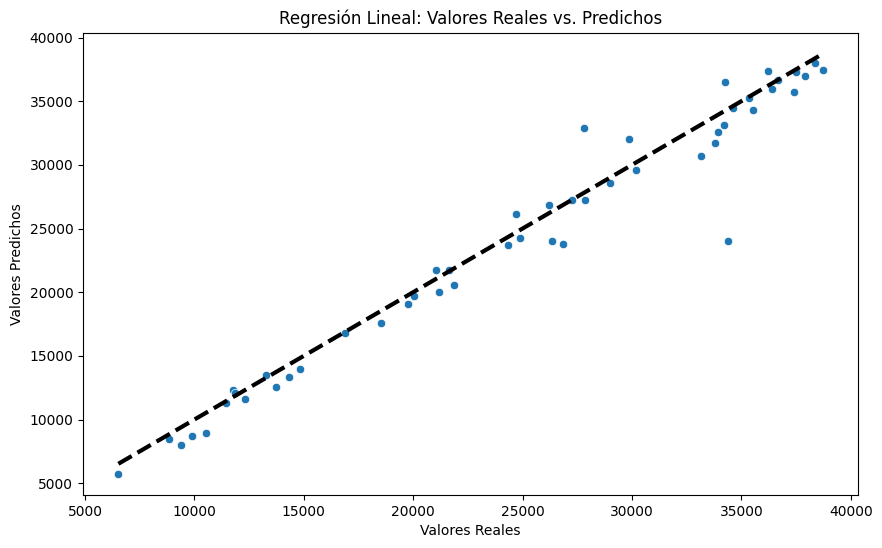

In [319]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal: Valores Reales vs. Predichos')
plt.show()

In [320]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Coeficiente de Determinación (R^2): {r2}')

Error Cuadrático Medio (MSE): 3990235.929285916
Error Absoluto Medio (MAE): 1201.9666078358703
Coeficiente de Determinación (R^2): 0.9583714250294264
